<a href="https://colab.research.google.com/github/andyrids/trackinsight/blob/main/trackinsight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%pip install haversine mapclassify folium -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.0 MB/s eta 0:00:00


In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame
from haversine import haversine_vector, Unit
from numpy.typing import ArrayLike, NDArray
from pandas import DataFrame, DatetimeIndex
from scipy.interpolate import pchip_interpolate

In [22]:
# sort array
# a = a[a[:, 0].argsort()]

In [23]:
# [[t, x, y], ...]
# np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:])

In [24]:
def euclidean_distance(x: NDArray, y: NDArray) -> ArrayLike:
    """"""
    return np.linalg.norm(x - y)

In [25]:
def assign_epoch_time(data: DataFrame, time_column: str = "ti_timestamp") -> DataFrame:
    """"""
    return data.assign(
        **{time_column: DatetimeIndex(data[time_column]).asi8 // 10**9}
    )

In [26]:
def sort_trajectories(
        data: DataFrame,
        uid_column: str = "ti_uid",
        time_column: str = "ti_timestamp"
    ) -> DataFrame:
    """Sort trajectories by unique identifier & timestamp."""
    return data.sort_values(by=[uid_column, time_column]).reset_index(drop=True)

In [27]:
def elapsed_seconds(
        data: DataFrame,
        time_column: str = "ti_timestamp"
    ) -> DataFrame:
    """Calculate elapsed seconds between trajectory points.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        time_column (str): Timestamp column.

    Returns:
        A DataFrame with a `ti_elapsed_time_s` column containing
        the elapsed time between trajectory points in seconds.
    """
    elapsed_time_s = data[time_column].diff()
    return data.assign(ti_elapsed_time_s=elapsed_time_s)

In [28]:
def elapsed_distance(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude"
    ) -> DataFrame:
    """Calculate the distance travelled between trajectory points.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        x_column (str): X-coordinate column.
        y_column (str): Y-coordinate column.

    Returns:
        A DataFrame with a `ti_distance_m` column, containing the
        distance travelled between trajectory points in meters.
    """
    latlong_columns = [latitude_column, longitude_column]
    distance_m = haversine_vector(
        data[latlong_columns], data[latlong_columns].shift(), Unit.METERS, check=False
    )

    return data.assign(ti_distance_m=distance_m)

In [29]:
def calculate_speed(
    data: DataFrame,
    elapsed_time_column: str = "ti_elapsed_time_s",
    elapsed_distance_column: str = "ti_distance_m"
) -> DataFrame:
    """Calculate the speed between trajectory points.

    NOTE: Speeds are calculated in m/s & Kn.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        elapsed_time_column (str): Elapsed time column.
        elapsed_distance_column (str): Elapsed distance column.

    Returns:
       A DataFrame with `ti_speed_mps` & `ti_speed_kts`
       speed columns.
    """
    speed_mps = data[elapsed_distance_column] / data[elapsed_time_column]
    speed_kts = speed_mps * 1.943844
    return data.assign(ti_speed_mps=speed_mps, ti_speed_kts=speed_kts)

In [46]:
def convert_to_geodataframe(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude",
        crs: str = "EPSG:4326"
    ) -> GeoDataFrame:
    """Convert trajectory data to a GeoDataFrame.

        Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        latitude_column (str): Latitude column.
        longitude_column (str): Longitude column.

    Returns:
        A GeoDataFrame.
    """
    geometry = gpd.points_from_xy(data[longitude_column], data[latitude_column], crs=crs)
    geoemetry_3857 = geometry.to_crs(epsg=3857)
    return (
        gpd.GeoDataFrame(data, geometry=geometry)
        .assign(geometry_3857=geoemetry_3857)
        #.set_geometry("geometry_3857")
    )

In [30]:
def transform_trajectories(
    data: DataFrame,
    uid_column: str,
    time_column: str,
    latitude_column: str,
    longitude_column: str,
) -> DataFrame:
    """Transform AIS trajectory data.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        time_column (str): Timestamp column.
        latitude_column (str): Latitude column.
        longitude_column (str): Longitude column.

    Returns:
        A DataFrame with transformed trajectory data.
    """
    if data[time_column].dtype.name == "datetime64[ns]":
        data = data.pipe(assign_epoch_time, time_column)

    data = data.filter([uid_column, time_column, latitude_column, longitude_column])
    ti_columns = ("ti_uid", "ti_timestamp", "ti_latitude", "ti_longitude")
    data = data.set_axis(ti_columns, axis="columns")

    grouped = data.groupby("ti_uid", as_index=False, group_keys=False)
    data = grouped[data.columns].apply(lambda x:
        x
        .pipe(sort_trajectories)
        .pipe(elapsed_seconds)
        .pipe(elapsed_distance)
        .pipe(calculate_speed),
    )

    return data

In [31]:
# AIS trajectory data
data = pd.read_csv("https://raw.githubusercontent.com/PilotLeaf/PyVT/main/traj_preprocess/ais_clean/data/1.csv", index_col=0)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308 entries, 0 to 307
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DRMMSI         308 non-null    int64  
 1   DRLATITUDE     308 non-null    float64
 2   DRLONGITUDE    308 non-null    float64
 3   DRDIRECTION    308 non-null    float64
 4   DRSPEED        308 non-null    float64
 5   DRGPSTIME      308 non-null    int64  
 6   STATUS         308 non-null    int64  
 7   DRTRUEHEADING  308 non-null    int64  
 8   DIRECTION      308 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 24.1 KB


In [33]:
data.head(5)

,DRMMSI,DRLATITUDE,DRLONGITUDE,DRDIRECTION,DRSPEED,DRGPSTIME,STATUS,DRTRUEHEADING,DIRECTION
INDEX,,,,,,,,,
0,244726000,31.172785,122.668333,278.6,12.9,1556415580,0,0,0.0
1,244726000,31.172983,122.667032,280.8,12.9,1556415599,0,0,2.2
2,244726000,31.173205,122.665447,279.3,12.9,1556415623,0,0,-1.5
3,244726000,31.173597,122.662968,280.3,12.9,1556415659,0,0,1.0
4,244726000,31.173783,122.661732,280.4,13.0,1556415677,0,0,0.1


In [34]:
ti_data = transform_trajectories(data, "DRMMSI", "DRGPSTIME", "DRLATITUDE", "DRLONGITUDE")
ti_data

,ti_uid,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts
INDEX,,,,,,,,
0,244726000,1556415580,31.172785,122.668333,NaN,NaN,NaN,NaN
1,244726000,1556415599,31.172983,122.667032,19.0,125.782026,6.620107,12.868455
2,244726000,1556415623,31.173205,122.665447,24.0,152.797062,6.366544,12.375569
3,244726000,1556415659,31.173597,122.662968,36.0,239.780926,6.660581,12.947131
4,244726000,1556415677,31.173783,122.661732,18.0,119.465403,6.636967,12.901228
...,...,...,...,...,...,...,...,...
303,244726000,1556445869,31.103215,122.331262,30.0,149.160800,4.972027,9.664844
304,244726000,1556445899,31.103185,122.329603,30.0,157.930635,5.264354,10.233084
305,244726000,1556445920,31.103173,122.328535,21.0,101.720586,4.843837,9.415664


In [96]:
gdf_ti_data = convert_to_geodataframe(ti_data)
gdf_ti_data = gdf_ti_data.assign(buffer=lambda x: x["geometry_3857"].buffer(1000, cap_style="square").to_crs(4326))
gdf_ti_data

,ti_uid,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts,geometry,geometry_3857,buffer
INDEX,,,,,,,,,,,
0,244726000,1556415580,31.172785,122.668333,NaN,NaN,NaN,NaN,POINT (122.66833 31.17278),POINT (13655376.399 3655208.953),"POLYGON ((122.67732 31.18047, 122.67732 31.165..."
1,244726000,1556415599,31.172983,122.667032,19.0,125.782026,6.620107,12.868455,POINT (122.66703 31.17298),POINT (13655231.506 3655234.757),"POLYGON ((122.67601 31.18067, 122.67601 31.165..."
2,244726000,1556415623,31.173205,122.665447,24.0,152.797062,6.366544,12.375569,POINT (122.66545 31.1732),POINT (13655055.065 3655263.598),"POLYGON ((122.67443 31.18089, 122.67443 31.165..."
3,244726000,1556415659,31.173597,122.662968,36.0,239.780926,6.660581,12.947131,POINT (122.66297 31.1736),POINT (13654779.17 3655314.557),"POLYGON ((122.67195 31.18128, 122.67195 31.165..."
4,244726000,1556415677,31.173783,122.661732,18.0,119.465403,6.636967,12.901228,POINT (122.66173 31.17378),POINT (13654641.513 3655338.842),"POLYGON ((122.67071 31.18147, 122.67071 31.166..."
...,...,...,...,...,...,...,...,...,...,...,...
303,244726000,1556445869,31.103215,122.331262,30.0,149.160800,4.972027,9.664844,POINT (122.33126 31.10322),POINT (13617853.761 3646160.843),"POLYGON ((122.34024 31.11091, 122.34024 31.095..."
304,244726000,1556445899,31.103185,122.329603,30.0,157.930635,5.264354,10.233084,POINT (122.3296 31.10318),POINT (13617669.148 3646156.943),"POLYGON ((122.33859 31.11088, 122.33859 31.095..."
305,244726000,1556445920,31.103173,122.328535,21.0,101.720586,4.843837,9.415664,POINT (122.32854 31.10317),POINT (13617550.226 3646155.425),"POLYGON ((122.33752 31.11086, 122.33752 31.095..."


In [97]:
gdf_ti_data

,ti_uid,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts,geometry,geometry_3857,buffer
INDEX,,,,,,,,,,,
0,244726000,1556415580,31.172785,122.668333,NaN,NaN,NaN,NaN,POINT (122.66833 31.17278),POINT (13655376.399 3655208.953),"POLYGON ((122.67732 31.18047, 122.67732 31.165..."
1,244726000,1556415599,31.172983,122.667032,19.0,125.782026,6.620107,12.868455,POINT (122.66703 31.17298),POINT (13655231.506 3655234.757),"POLYGON ((122.67601 31.18067, 122.67601 31.165..."
2,244726000,1556415623,31.173205,122.665447,24.0,152.797062,6.366544,12.375569,POINT (122.66545 31.1732),POINT (13655055.065 3655263.598),"POLYGON ((122.67443 31.18089, 122.67443 31.165..."
3,244726000,1556415659,31.173597,122.662968,36.0,239.780926,6.660581,12.947131,POINT (122.66297 31.1736),POINT (13654779.17 3655314.557),"POLYGON ((122.67195 31.18128, 122.67195 31.165..."
4,244726000,1556415677,31.173783,122.661732,18.0,119.465403,6.636967,12.901228,POINT (122.66173 31.17378),POINT (13654641.513 3655338.842),"POLYGON ((122.67071 31.18147, 122.67071 31.166..."
...,...,...,...,...,...,...,...,...,...,...,...
303,244726000,1556445869,31.103215,122.331262,30.0,149.160800,4.972027,9.664844,POINT (122.33126 31.10322),POINT (13617853.761 3646160.843),"POLYGON ((122.34024 31.11091, 122.34024 31.095..."
304,244726000,1556445899,31.103185,122.329603,30.0,157.930635,5.264354,10.233084,POINT (122.3296 31.10318),POINT (13617669.148 3646156.943),"POLYGON ((122.33859 31.11088, 122.33859 31.095..."
305,244726000,1556445920,31.103173,122.328535,21.0,101.720586,4.843837,9.415664,POINT (122.32854 31.10317),POINT (13617550.226 3646155.425),"POLYGON ((122.33752 31.11086, 122.33752 31.095..."


In [104]:
gby = gdf_ti_data.set_index(pd.to_timedelta(gdf_ti_data["ti_timestamp"], unit="s")).groupby(pd.Grouper(freq="1h"))

buffer_union = gby["buffer"].agg(lambda x: x.union_all()).simplify(0.001)

gpd.GeoDataFrame(
    gby[["ti_timestamp"]]
    .agg(
        start=pd.NamedAgg(column="ti_timestamp", aggfunc="first"),
        end=pd.NamedAgg(column="ti_timestamp", aggfunc="last")
    )
    .assign(
        segment_polygon=buffer_union,
        start=lambda x: pd.to_datetime(x["start"], unit="s").dt.strftime("%Y-%m-%dT%H:%M:%S"),
        end=lambda x: pd.to_datetime(x["end"], unit="s").dt.strftime("%Y-%m-%dT%H:%M:%S")
    ),
    geometry=buffer_union,
    crs="EPSG:4326"
).reset_index(drop=True).explore(column="start")

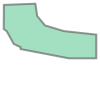

In [103]:
buffer_union.iat[0].simplify(0.001)

In [61]:
m = gdf_ti_data.explore(column="ti_uid")
gdf_ti_data.set_geometry("buffer").explore(column="ti_uid", m=m, fillopacity=0.1, fill=False)

In [ ]:
distance_mask = ~ti_data["ti_speed_mps"].isin((np.nan, np.inf, -np.inf))
distances_m = ti_data["ti_distance_m"].to_numpy()[distance_mask]

# xi should be the cumulative distance
xi = np.cumsum(distances_m)

# yi should contain the columns you want to interpolate: latitude, longitude, and timestamp
yi = (
    ti_data
    .loc[distance_mask]
    .filter(["ti_latitude", "ti_longitude", "ti_speed_kts", "ti_timestamp"])
    .to_numpy()
)

resolution = 60
num = int(np.ceil(xi[-1] / 60))

x = np.linspace(xi[0], xi[-1], num=num, endpoint=True)
y = pchip_interpolate(xi, yi, x, axis=0)

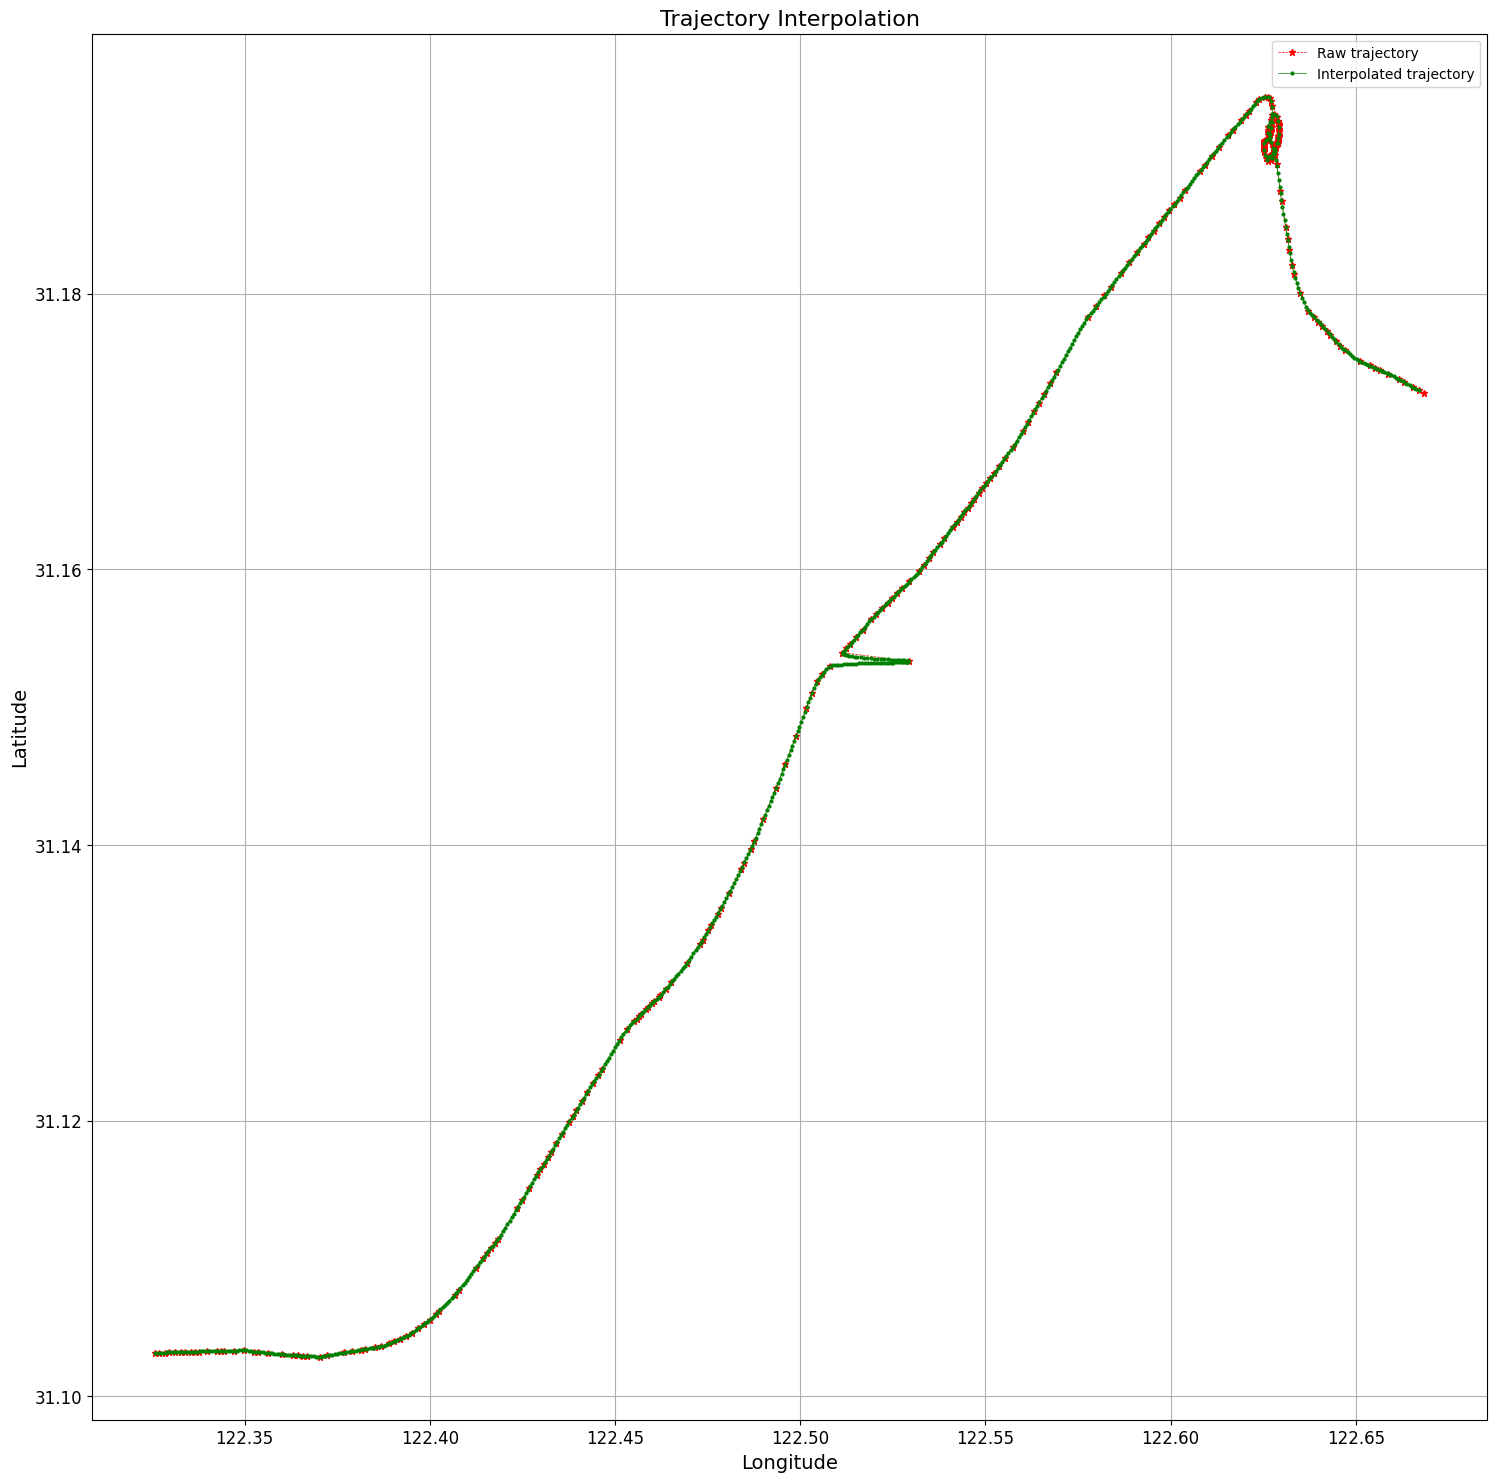

<Figure size 1800x1800 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,18), dpi=100)

plt.plot(
    ti_data['ti_longitude'],
    ti_data['ti_latitude'],
    marker='*',
    ms=5,
    linestyle='--',
    color='red',
    linewidth=0.5,
    label='Raw trajectory'
)

plt.plot(
    y[:,1],
    y[:,0],
    marker='o',
    ms=2,
    linestyle='-',
    color='g',
    linewidth=0.5,
    label='Interpolated trajectory'
)

plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('Longitude', fontdict={'size': 14})
plt.ylabel('Latitude', fontdict={'size': 14})
plt.title('Trajectory Interpolation', fontdict={'size': 16})
plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()
plt.legend()
plt.figure(figsize=(18,18), dpi=100)
plt.tight_layout()
plt.show()

In [ ]:
gpd.GeoDataFrame(
    data=ti_data,
    geometry=gpd.points_from_xy(ti_data['ti_longitude'], ti_data['ti_latitude']),
    crs="EPSG:4326"
).explore()

In [ ]:
import pyproj
import shapely

In [ ]:
geometry = gpd.points_from_xy(data_transformed.ti_x, data_transformed.ti_y)
geo_data_transformed = gpd.GeoDataFrame(data_transformed, geometry=geometry, crs="EPSG:4326")

In [ ]:
geo_data_transformed

ti_timestamp        ti_x       ti_y  ti_elapsed_time_s  \
ti_uid                                                                  
244726000 0      1556415580  122.668333  31.172785                NaN   
          1      1556415599  122.667032  31.172983               19.0   
          2      1556415623  122.665447  31.173205               24.0   
          3      1556415659  122.662968  31.173597               36.0   
          4      1556415677  122.661732  31.173783               18.0   
...                     ...         ...        ...                ...   
          303    1556445869  122.331262  31.103215               30.0   
          304    1556445899  122.329603  31.103185               30.0   
          305    1556445920  122.328535  31.103173               21.0   
          306    1556445950  122.326922  31.103153               30.0   
          307    1556445969  122.325902  31.103155               19.0   

               ti_distance_m  ti_speed_mps  ti_speed_kts  \
ti_uid                                                     
244726000 0              NaN           NaN           NaN   
          1       125.782026      6.620107     12.868455   
          2       152.797062      6.366544     12.375569   
          3       239.780926      6.660581     12.947131   
          4       119.465403      6.636967     12.901228   
...                      ...           ...           ...   
          303     149.160800      4.972027      9.664844   
          304     157.930635      5.264354     10.233084   
          305     101.720586      4.843837      9.415664   
          306     153.617611      5.120587      9.953622   
          307      97.113893      5.111258      9.935487   

                                 geometry  
ti_uid                                     
244726000 0    POINT (122.66833 31.17278)  
          1    POINT (122.66703 31.17298)  
          2     POINT (122.66545 31.1732)  
          3     POINT (122.66297 31.1736)  
          4    POINT (122.66173 31.17378)  
...                                   ...  
          303  POINT (122.33126 31.10322)  
          304   POINT (122.3296 31.10318)  
          305  POINT (122.32854 31.10317)  
          306  POINT (122.32692 31.10315)  
          307   POINT (122.3259 31.10316)  

[308 rows x 8 columns]

In [ ]:
linestring = shapely.LineString(geo_data_transformed.geometry)

In [ ]:
# extracts the coordinates of all points in the linestrings and their corresponding linestring index
geom, index = shapely.get_coordinates(linestring, return_index=True)

In [ ]:
# trajectory points belowng to one segment Linestring (one index value)
index

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
geom.shape, geom[:-1, 0].shape

((308, 2), (307,))

In [ ]:
# creates a mask to handle cases where line segments might overlap
no_mix_mask = index[:-1] == index[1:]
no_mix_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
geo_data_transformed["ti_distance_m"].dropna()

ti_uid        
244726000  1      125.782026
           2      152.797062
           3      239.780926
           4      119.465403
           5      280.533425
                     ...    
           303    149.160800
           304    157.930635
           305    101.720586
           306    153.617611
           307     97.113893
Name: ti_distance_m, Length: 307, dtype: float64

array([1.25782026e+02, 1.52797062e+02, 2.39780926e+02, 1.19465403e+02,
       2.80533425e+02, 2.05772117e+02, 1.44699887e+02, 1.29376217e+02,
       2.47860479e+02, 3.93165001e+02, 1.52003300e+02, 1.11206298e+02,
       1.41254102e+02, 1.05485871e+02, 1.15273426e+02, 1.06691712e+02,
       1.15394115e+02, 1.63451211e+02, 2.43941970e+02, 2.23073733e+02,
       9.47399186e+01, 1.35829990e+02, 1.03624205e+02, 1.05667635e+02,
       2.34563656e+02, 8.87978456e+01, 2.33937870e+02, 8.40942508e+01,
       4.41838492e+01, 3.92871465e+01, 3.97137044e+01, 1.11810811e+02,
       2.29298598e+01, 1.06753698e+01, 8.56268755e+00, 2.82036725e+01,
       9.55548530e+01, 8.34437584e+01, 9.24105838e+01, 3.63026500e+01,
       1.29676905e+01, 8.35783403e+00, 2.39890571e+00, 3.39825114e+00,
       8.18918575e+00, 1.78216184e+00, 5.00883647e+00, 1.21950622e+01,
       2.45267791e+01, 1.85695784e-01, 2.82414359e+00, 3.86962288e+00,
       2.33828371e+00, 8.10790267e-01, 1.69229033e+01, 3.68816192e+01,
      

In [ ]:
%timeit geo_data_transformed["ti_distance_m"].sum()

32.5 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
distances = geo_data_transformed["ti_distance_m"].dropna().to_numpy()
%timeit np.bincount((index[:-1])[no_mix_mask], weights=distances[no_mix_mask])

4.39 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
